# Clustering

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Caricamento del dataset
df = pd.read_csv('../Datasets/atp_tennis.csv')

# Pre-elaborazione
# Rimuovere righe con valori mancanti (se presenti)
df = df.dropna()

In [10]:
# Creiamo nuove feature per ogni partita
df_matches = pd.DataFrame()

# 1. Differenza di ranking tra i giocatori
df_matches['ranking_diff'] = abs(df['Rank_1'] - df['Rank_2'])

# 2. Media ranking dei due giocatori
df_matches['avg_ranking'] = (df['Rank_1'] + df['Rank_2']) / 2

# 3. Differenza punti (se disponibili)
if 'Pts_1' in df.columns and 'Pts_2' in df.columns:
    df_matches['points_diff'] = abs(df['Pts_1'] - df['Pts_2'])
    df_matches['total_points'] = df['Pts_1'] + df['Pts_2']

# 4. Competitività della partita (basata sul punteggio)
def get_match_competitiveness(row):
    sets = row['Score'].split(' ')
    total_games = 0
    games_diff = 0
    for set_score in sets:
        if '-' in set_score:
            games = set_score.split('-')
            total_games += int(games[0]) + int(games[1])
            games_diff += abs(int(games[0]) - int(games[1]))
    return total_games, games_diff

df_matches[['total_games', 'games_diff']] = df.apply(get_match_competitiveness, axis=1, result_type='expand')

df_matches.describe()

,ranking_diff,avg_ranking,points_diff,total_points,total_games,games_diff
count,48344.000000,48344.000000,48344.000000,48344.000000,48344.000000,48344.000000
mean,71.586733,74.617957,1344.508026,2961.847882,25.731135,7.059945
std,118.904843,73.819479,1988.353278,2812.322493,8.489996,2.903114
min,0.000000,1.500000,0.000000,7.000000,12.000000,2.000000
25%,18.000000,35.000000,253.000000,1365.000000,19.000000,5.000000
50%,40.000000,57.500000,610.000000,2001.500000,24.000000,7.000000
75%,78.000000,89.000000,1460.000000,3325.000000,31.000000,9.000000
max,4911.000000,2459.500000,16641.000000,25735.000000,183.000000,24.000000


In [11]:
########################## 
'''

# Aggiungiamo nuove feature al DataFrame df_matches

# 1. Caratteristiche del torneo
df_matches['tournament_level'] = df['Series'].map({
    'Masters Cup': 5,
    'Masters 1000': 4,
    'ATP500': 3,
    'ATP250': 2,
    'International': 1
})

# 2. Superficie e tipo di campo
df_matches['surface_type'] = pd.get_dummies(df['Surface'], prefix='surface')
df_matches['court_type'] = pd.get_dummies(df['Court'], prefix='court')

# 3. Fase del torneo
df_matches['tournament_round'] = df['Round'].map({
    '1st Round': 1,
    '2nd Round': 2,
    'Quarterfinals': 3,
    'Semifinals': 4,
    'The Final': 5
})

# 4. Stagionalità
df_matches['month'] = pd.to_datetime(df['Date']).dt.month
df_matches['season'] = pd.to_datetime(df['Date']).dt.month.map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

# 5. Quote e probabilità implicite (se disponibili)
if 'Odd_1' in df.columns and 'Odd_2' in df.columns:
    df_matches['odds_ratio'] = df['Odd_1'] / df['Odd_2']
    df_matches['implied_prob_diff'] = abs((1/df['Odd_1']) - (1/df['Odd_2']))

# 6. Analisi dettagliata del punteggio
def analyze_score(row):
    sets = row['Score'].split(' ')
    tiebreaks = sum(1 for set_score in sets if '7-6' in set_score or '6-7' in set_score)
    max_games_diff = max(abs(int(s.split('-')[0]) - int(s.split('-')[1])) 
                        for s in sets if '-' in s)
    total_sets = len(sets)
    return tiebreaks, max_games_diff, total_sets

df_matches[['tiebreaks', 'max_games_diff', 'total_sets']] = \
    df.apply(analyze_score, axis=1, result_type='expand')

# 7. Statistiche storiche dei giocatori (richiede elaborazione aggiuntiva)
def get_player_stats(player_id, date):
    # Filtra le partite precedenti del giocatore
    previous_matches = df[
        ((df['Player_1'] == player_id) | (df['Player_2'] == player_id)) &
        (pd.to_datetime(df['Date']) < date)
    ]
    
    wins = len(previous_matches[previous_matches['Winner'] == player_id])
    total_matches = len(previous_matches)
    win_rate = wins / total_matches if total_matches > 0 else 0
    
    return win_rate, total_matches

# Applica le statistiche storiche
df_matches['player1_win_rate'], df_matches['player1_experience'] = \
    zip(*df.apply(lambda x: get_player_stats(x['Player_1'], pd.to_datetime(x['Date'])), axis=1))
df_matches['player2_win_rate'], df_matches['player2_experience'] = \
    zip(*df.apply(lambda x: get_player_stats(x['Player_2'], pd.to_datetime(x['Date'])), axis=1))

# 8. Indice di esperienza e forma
df_matches['experience_diff'] = abs(df_matches['player1_experience'] - df_matches['player2_experience'])
df_matches['form_diff'] = abs(df_matches['player1_win_rate'] - df_matches['player2_win_rate']) 
'''

"\n\n# Aggiungiamo nuove feature al DataFrame df_matches\n\n# 1. Caratteristiche del torneo\ndf_matches['tournament_level'] = df['Series'].map({\n    'Masters Cup': 5,\n    'Masters 1000': 4,\n    'ATP500': 3,\n    'ATP250': 2,\n    'International': 1\n})\n\n# 2. Superficie e tipo di campo\ndf_matches['surface_type'] = pd.get_dummies(df['Surface'], prefix='surface')\ndf_matches['court_type'] = pd.get_dummies(df['Court'], prefix='court')\n\n# 3. Fase del torneo\ndf_matches['tournament_round'] = df['Round'].map({\n    '1st Round': 1,\n    '2nd Round': 2,\n    'Quarterfinals': 3,\n    'Semifinals': 4,\n    'The Final': 5\n})\n\n# 4. Stagionalità\ndf_matches['month'] = pd.to_datetime(df['Date']).dt.month\ndf_matches['season'] = pd.to_datetime(df['Date']).dt.month.map({\n    12: 'Winter', 1: 'Winter', 2: 'Winter',\n    3: 'Spring', 4: 'Spring', 5: 'Spring',\n    6: 'Summer', 7: 'Summer', 8: 'Summer',\n    9: 'Fall', 10: 'Fall', 11: 'Fall'\n})\n\n# 5. Quote e probabilità implicite (se dispon

Preprocessing dei dati

In [12]:
# Gestione dei valori mancanti
df_matches = df_matches.fillna(df_matches.mean())

# Standardizzazione delle feature
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_matches)
df_matches_scaled = pd.DataFrame(features_scaled, columns=df_matches.columns)

## Visualizzazione dei dati tramite distribuzioni e grafici

### Come sono distribuite le vittorie tra i giocatori?

In [13]:
# 1. Distribuzione del numero di vittorie
plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')
sns.histplot(data=vincitori['total_wins'], kde=True, bins=40)
plt.title('Distribuzione del numero di vittorie per giocatore')
plt.xlabel('Numero di vittorie')
plt.ylabel('Frequenza')
plt.show()

NameError: name 'vincitori' is not defined

<Figure size 1200x600 with 0 Axes>

### La relazione tra ranking e vittorie

<Figure size 1800x1200 with 0 Axes>

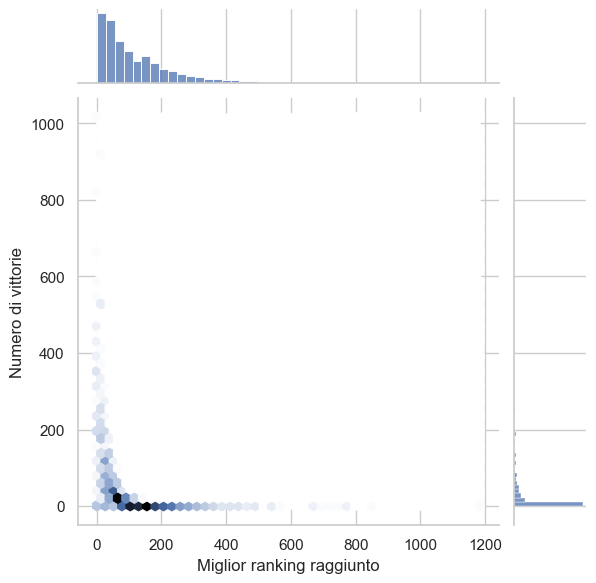

In [73]:
# 2. Relazione tra vittorie e ranking migliore
plt.figure(figsize=(18, 12))
sns.set_style('whitegrid')
sns.jointplot(data=vincitori, x='best_rank', y='total_wins', kind='hex')
plt.xlabel('Miglior ranking raggiunto')
plt.ylabel('Numero di vittorie')
plt.show()

### Come si distribuiscono le vittorie sulle diverse superfici

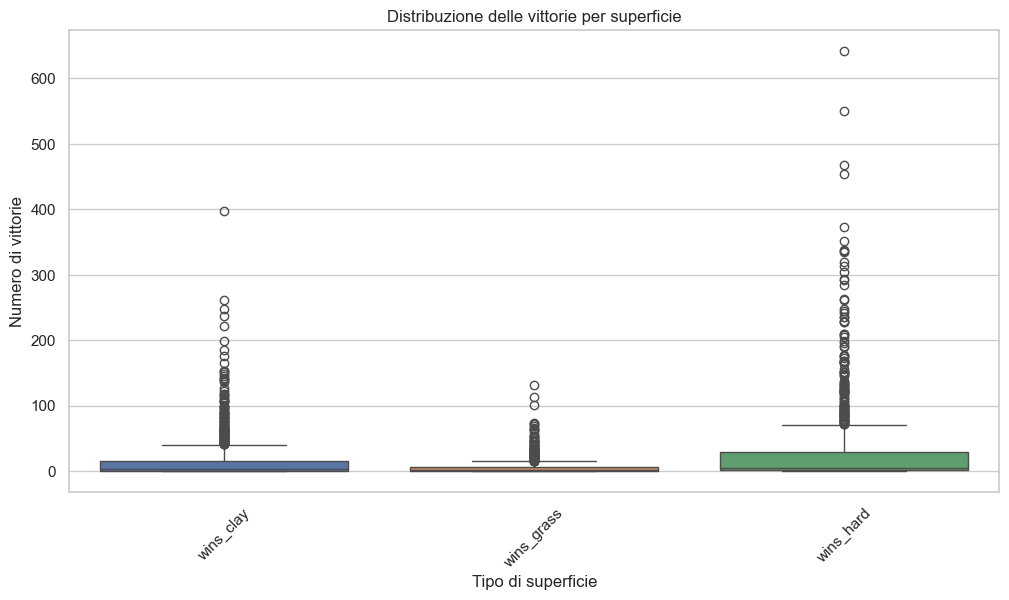

In [74]:
# 3. Distribuzione delle vittorie per superficie
surface_columns = [col for col in vincitori.columns if col.startswith('wins_')]
surface_data = vincitori[surface_columns]

plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')
sns.boxplot(data=surface_data)
plt.title('Distribuzione delle vittorie per superficie')
plt.xlabel('Tipo di superficie')
plt.ylabel('Numero di vittorie')
plt.xticks(rotation=45)
plt.show()

### Chi sono i giocatori più attivi?


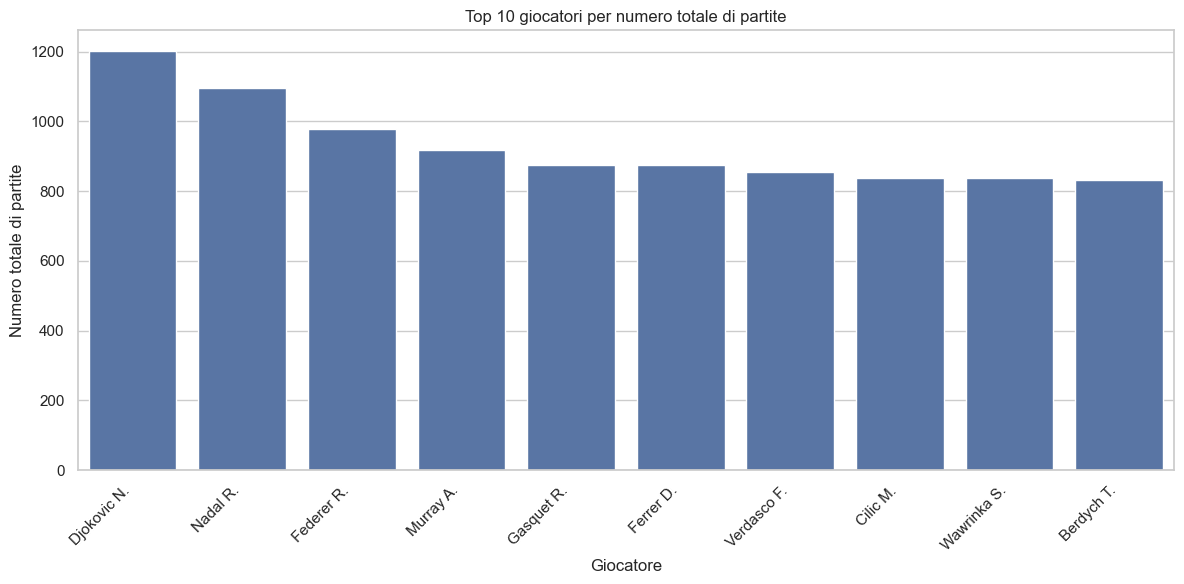

In [75]:
# 4. Top 10 giocatori per numero totale di partite
plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')
top_10_matches = vincitori.nlargest(10, 'total_matches')
sns.barplot(data=top_10_matches, x=top_10_matches.index, y='total_matches')
plt.title('Top 10 giocatori per numero totale di partite')
plt.xlabel('Giocatore')
plt.ylabel('Numero totale di partite')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Come sono correlate le diverse statistiche tra loro?

La matrice di correlazione è uno strumento molto utile per capire come le variabili del tuo dataset siano collegate tra loro. Essa mostra quanto due variabili siano correlate tra loro: se il valore della correlazione è vicino a 1, significa che c’è una forte correlazione positiva, se è vicino a -1, c’è una forte correlazione negativa, mentre un valore vicino a 0 indica che non c’è correlazione.

Passaggi per calcolare e visualizzare la matrice di correlazione:

1.	Calcolare la matrice di correlazione: Usiamo la funzione .corr() di Pandas, che calcola la correlazione tra le variabili numeriche nel DataFrame.
    
2.	Visualizzare la matrice di correlazione: Usiamo una heatmap per visualizzare la matrice, che rende più facile interpretare i valori di correlazione.

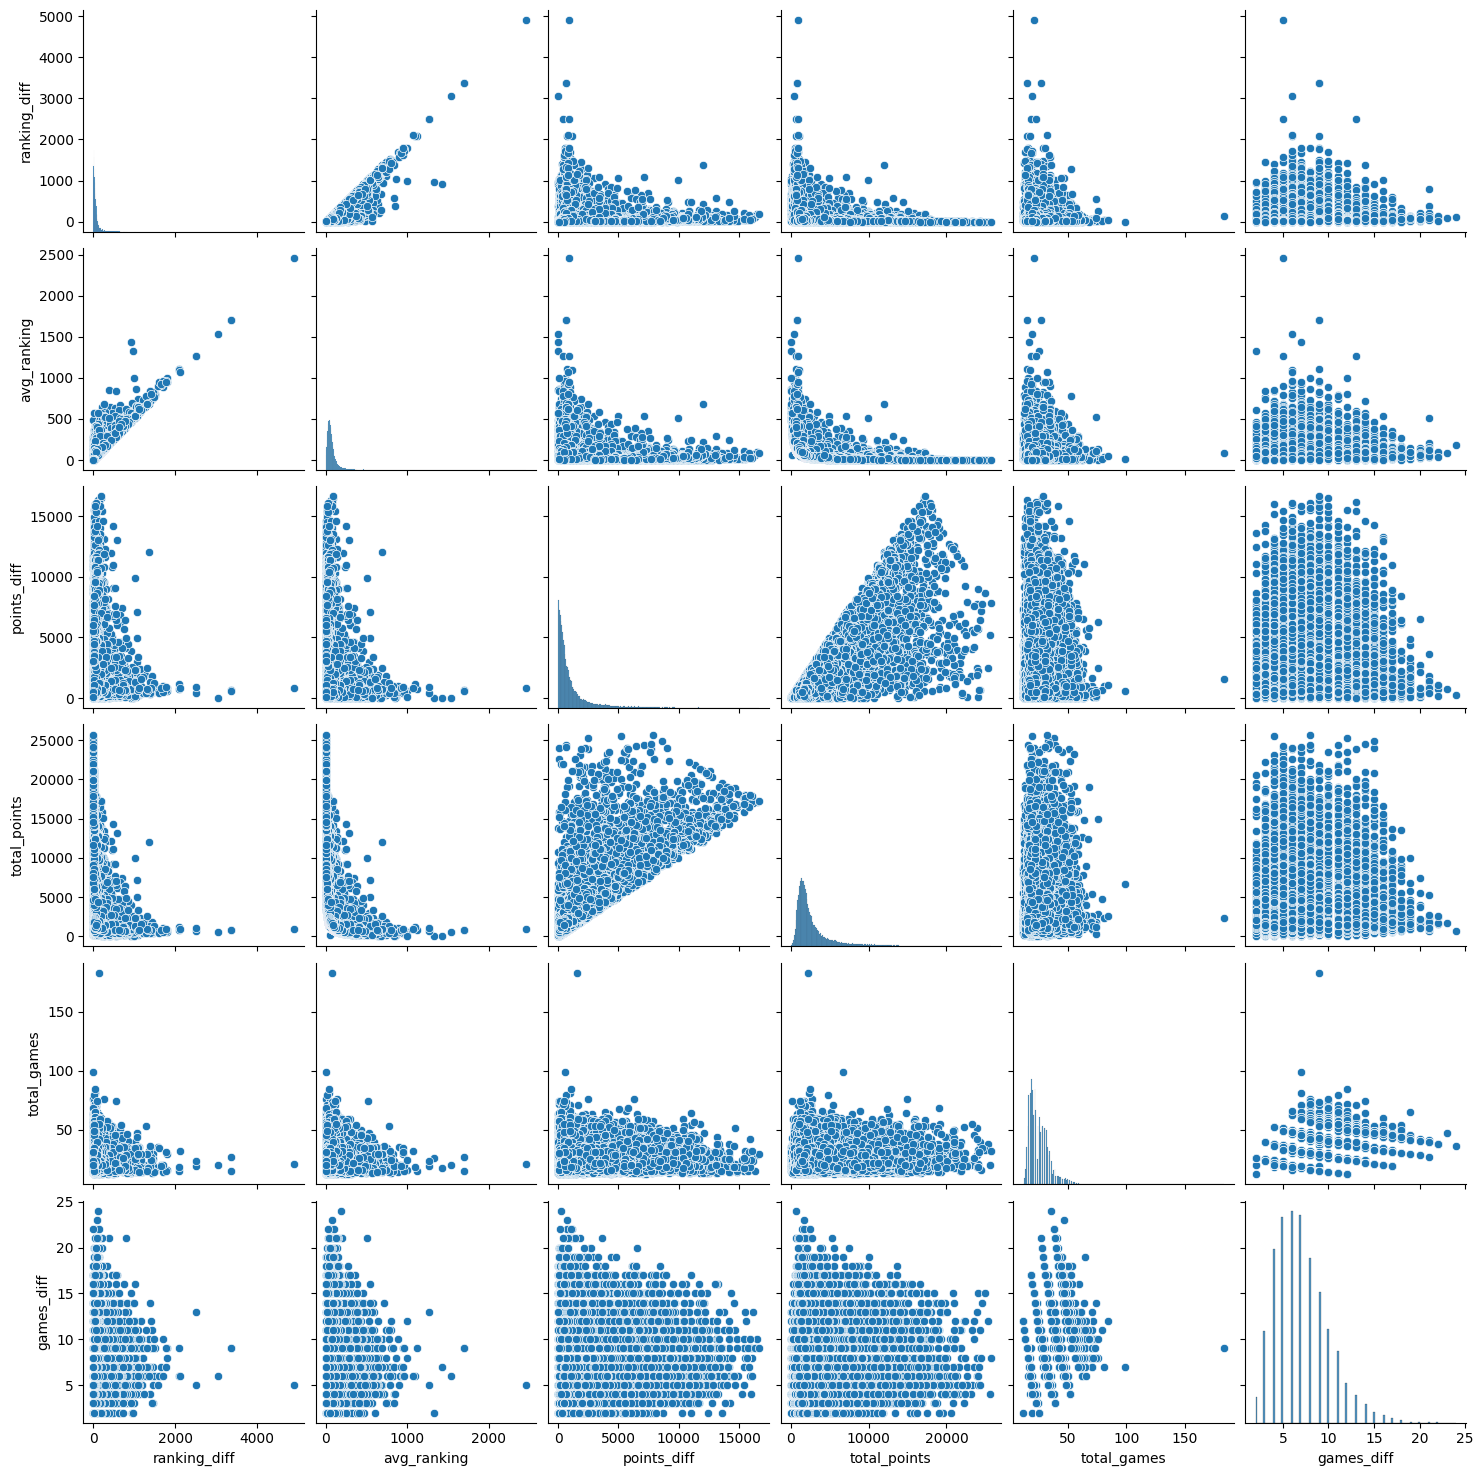

In [7]:
# sns.pairplot(): È una funzione di Seaborn che genera un pairplot, ovvero una matrice di grafici a dispersione tra tutte le coppie di colonne del DataFrame. 
# Inoltre, genera anche istogrammi lungo la diagonale per mostrare la distribuzione di ciascuna variabile.

sns.pairplot(df_matches)
plt.show()

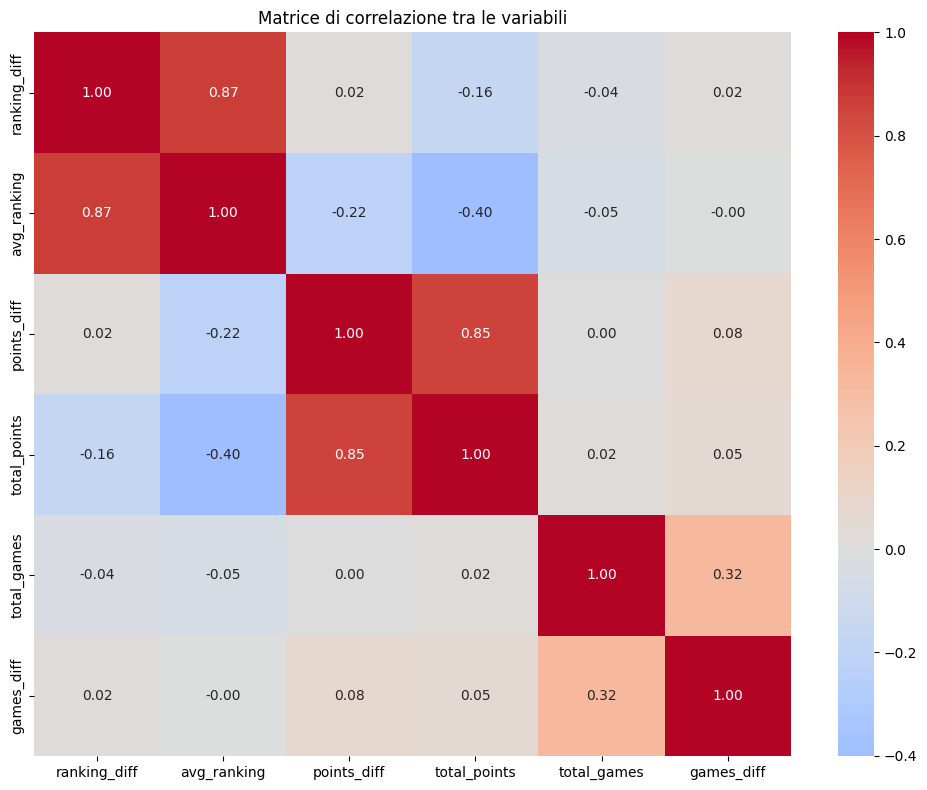

In [8]:
plt.figure(figsize=(10, 8))
correlation_matrix = df_matches.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('Matrice di correlazione tra le variabili')
plt.tight_layout()
plt.show()



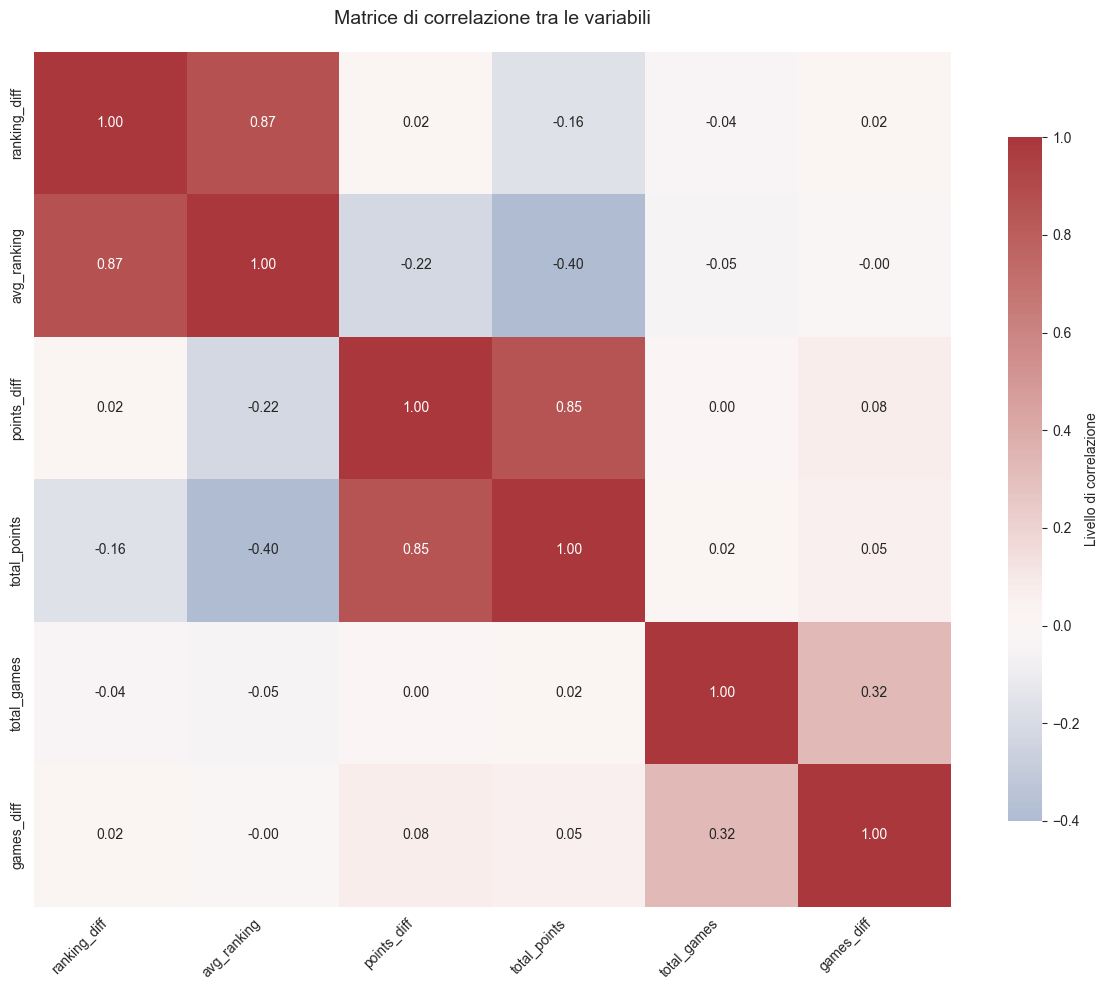

In [14]:
# Visualizzazione diversamente brutta

import matplotlib.pyplot as plt
import seaborn as sns

# Creazione della figura
plt.figure(figsize=(12, 10))

# Calcolo della matrice di correlazione
correlation_matrix = df_matches.select_dtypes(include=['float64', 'int64']).corr()

# Creazione della heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,            # Mostra i valori numerici
    cmap='vlag',           # Colormap con maggior contrasto
    fmt='.2f',             # Formato dei numeri (2 cifre decimali)
    center=0,              # Centra i colori intorno a 0
    cbar_kws={'shrink': 0.8, 'label': 'Livello di correlazione'}  # Personalizza la color bar
)

# Miglioramento dell'aspetto
plt.xticks(rotation=45, ha='right', fontsize=10)  # Ruota e ridimensiona i tick dell'asse X
plt.yticks(fontsize=10)                           # Ridimensiona i tick dell'asse Y
plt.title('Matrice di correlazione tra le variabili', fontsize=14, pad=20)  # Titolo con padding
plt.tight_layout()

# Mostra il grafico
plt.show()

La PCA (Principal Component Analysis) è una tecnica di riduzione della dimensionalità che consente di ridurre il numero di variabili, mantenendo la maggior parte dell’informazione (varianza) del dataset originale. PCA trova delle combinazioni lineari delle variabili originali chiamate componenti principali che spiegano la maggior parte della varianza nel dataset.

Quando hai un dataset con molte feature correlate, come nel tuo caso, la PCA ti permette di ridurre il numero di variabili senza perdere informazioni cruciali, migliorando l’efficienza computazionale e la comprensibilità del modello.

Passaggi per applicare PCA:

1.	Preparare i dati: È importante normalizzare i dati prima di applicare la PCA, poiché PCA è sensibile alla scala delle variabili.

2.	Applicare PCA: Usare PCA di Scikit-learn per ridurre il numero di componenti.

3.	Scegliere il numero di componenti: Decidere quante componenti principali mantenere. Generalmente si mantiene abbastanza componenti per spiegare una percentuale significativa della varianza (ad esempio, l’80% della varianza).

Codice per applicare la PCA:

1.	Normalizzazione dei Dati: Prima di applicare PCA, bisogna normalizzare i dati (ridurre i valori a una scala comune).

2.	Applicazione della PCA: Dopo aver normalizzato i dati, possiamo applicare la PCA e ridurre il numero di componenti.

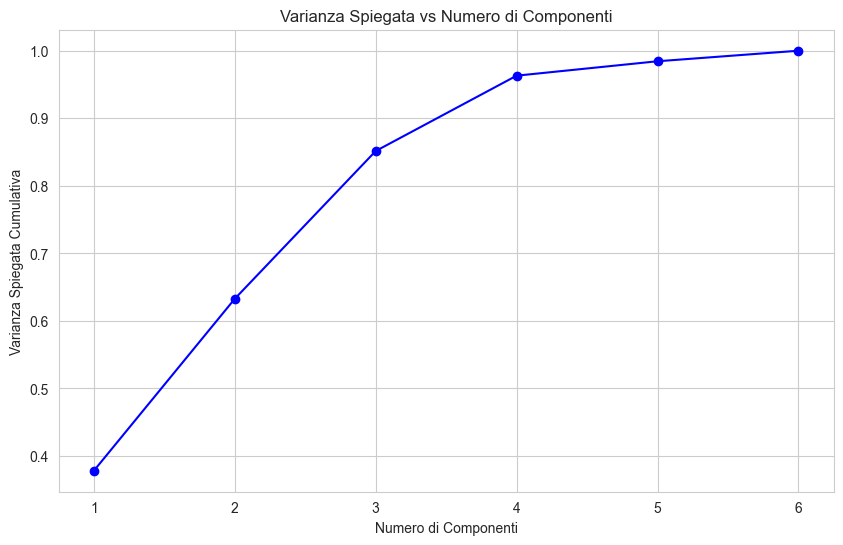


Varianza spiegata da ogni componente:
Componente 1: 0.378 (37.8%)
Componente 2: 0.255 (25.5%)
Componente 3: 0.219 (21.9%)
Componente 4: 0.112 (11.2%)
Componente 5: 0.021 (2.1%)
Componente 6: 0.016 (1.6%)

Matrice dei componenti principali:
     ranking_diff  avg_ranking  points_diff  total_points  total_games  \
PC1      0.441930     0.552627    -0.450499     -0.537508    -0.061289   
PC2      0.576148     0.409823     0.547044      0.412008     0.047064   
PC3     -0.048307    -0.018233    -0.123958     -0.112530     0.708754   
PC4     -0.057937    -0.033718    -0.030264     -0.056844    -0.700934   
PC5      0.148077     0.002204    -0.693184      0.704832    -0.018919   
PC6     -0.667185     0.724689     0.031755      0.169271     0.005398   

     games_diff  
PC1   -0.060680  
PC2    0.169928  
PC3    0.683354  
PC4    0.707143  
PC5    0.020475  
PC6    0.000209  


In [18]:
# Selezione delle features numeriche per PCA
features_for_pca = df_matches.select_dtypes(include=[np.number]).columns
X = df_matches[features_for_pca]

# 1. Normalizzazione dei dati
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Applicazione della PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 3. Visualizzazione della varianza spiegata
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.xlabel('Numero di Componenti')
plt.ylabel('Varianza Spiegata Cumulativa')
plt.title('Varianza Spiegata vs Numero di Componenti')
plt.grid(True)
plt.show()

# Stampa della varianza spiegata per ogni componente
print("\nVarianza spiegata da ogni componente:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"Componente {i+1}: {var:.3f} ({var*100:.1f}%)")

# Matrice dei componenti
componenti_df = pd.DataFrame(
    pca.components_,
    columns=features_for_pca,
    index=[f'PC{i+1}' for i in range(len(pca.components_))]
)

print("\nMatrice dei componenti principali:")
print(componenti_df)

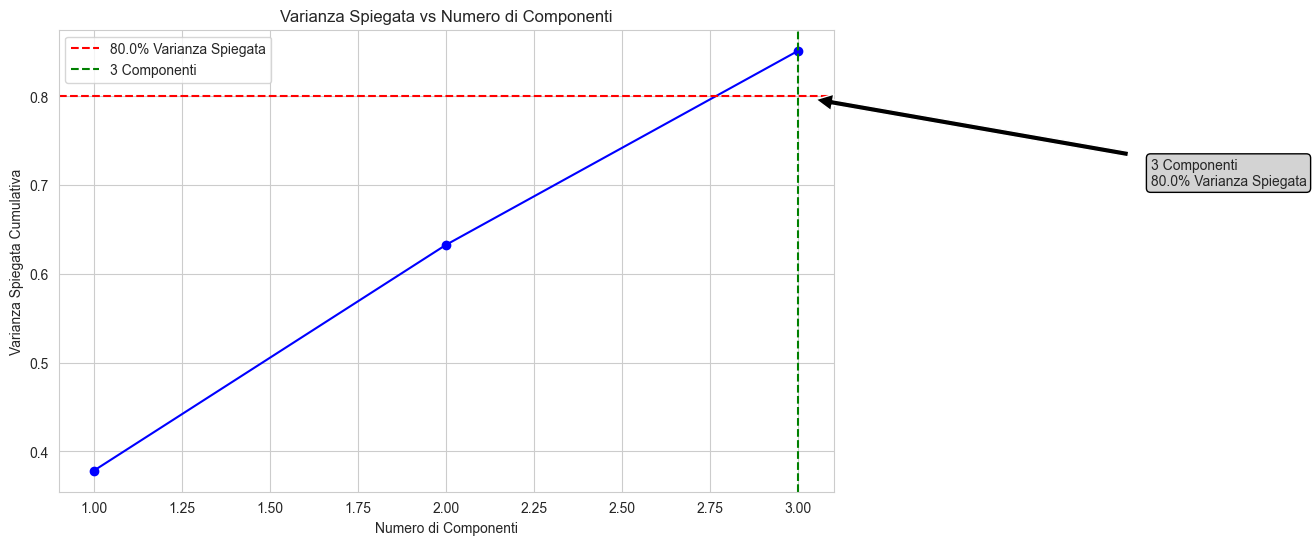

In [38]:
# 3. Visualizzazione della varianza spiegata
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.xlabel('Numero di Componenti')
plt.ylabel('Varianza Spiegata Cumulativa')
plt.title('Varianza Spiegata vs Numero di Componenti')
plt.grid(True)

# Annotazione per il punto di scelta delle componenti
threshold = 0.8  # Soglia di varianza spiegata (80%)
num_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= threshold) + 1

plt.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold*100}% Varianza Spiegata')
plt.axvline(x=num_components, color='g', linestyle='--', label=f'{num_components} Componenti')

plt.annotate(f'{num_components} Componenti\n{threshold*100}% Varianza Spiegata', 
             xy=(num_components, threshold), 
             xytext=(num_components+1, threshold-0.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10, 
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightgray'))

plt.legend()
plt.show()

Scelgo il numero di compnenti principali che corrisponde all'80% della varianza spiegata -> dunque 3 COMPONENTI

## K-Means

**metodo empirico**

**The Elbow Method to find the No. of Optimal Clusters**

WCSS (Within-Cluster Sum of Square) is the sum of squared distance between each point and the centroid in a cluster. 

Text(0, 0.5, 'wcss')

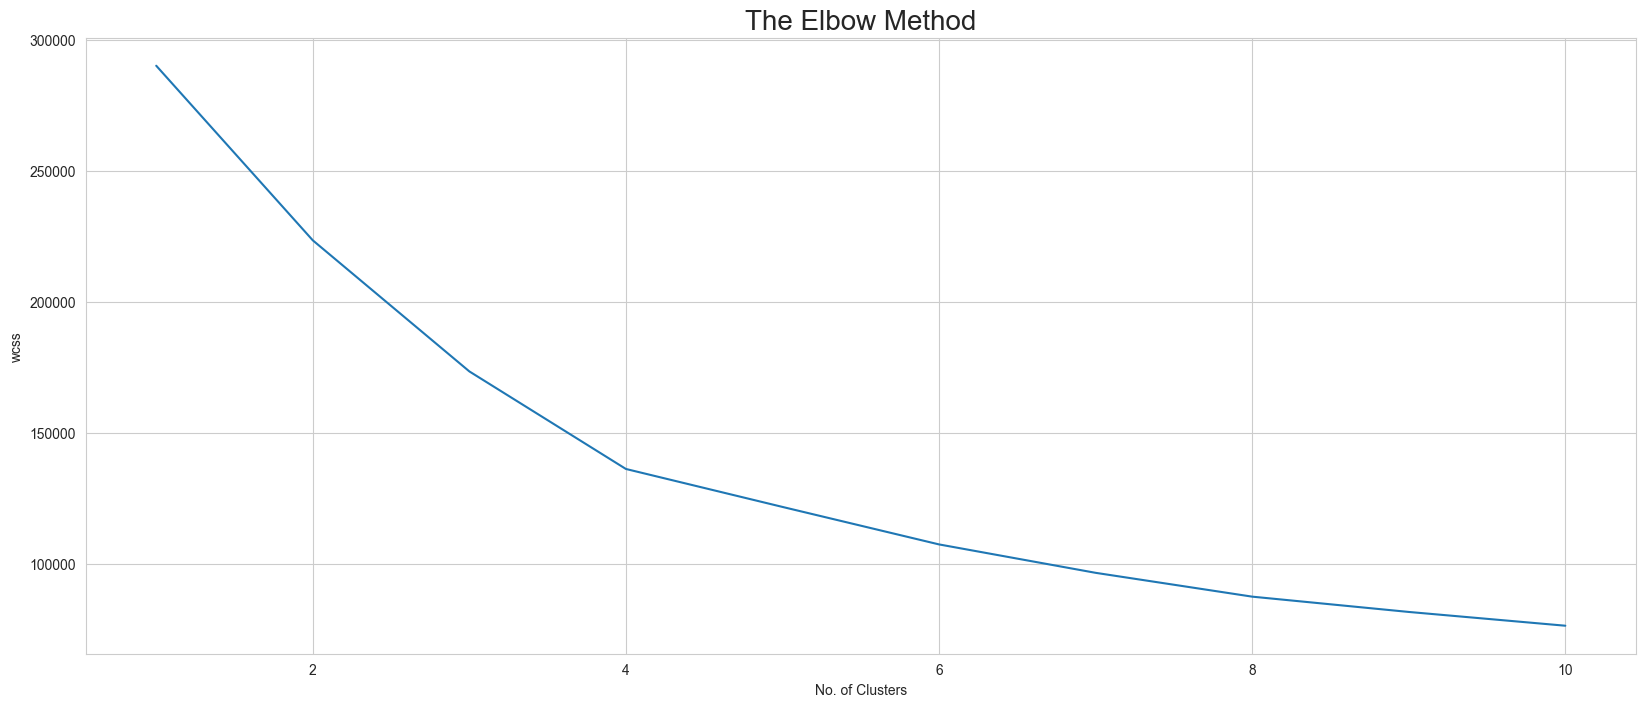

In [23]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(df_matches_scaled)
    wcss.append(km.inertia_)

plt.figure(figsize=(20,8))
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')

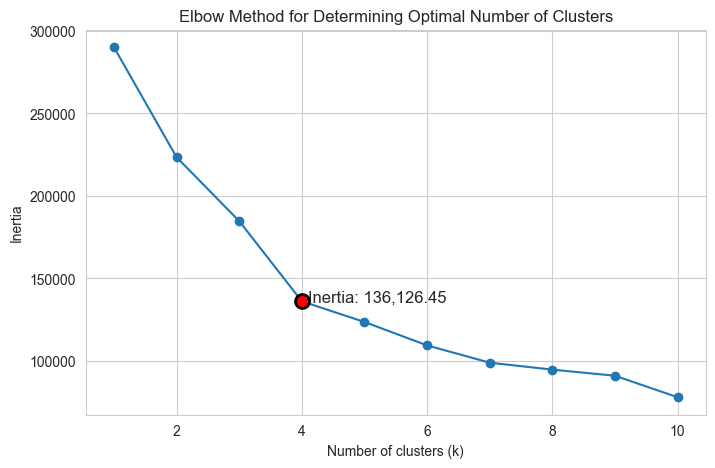


Number and percentage of customers in each cluster:
Cluster 1: 21868 customers (45.23%)
Cluster 0: 20154 customers (41.69%)
Cluster 2: 4525 customers (9.36%)
Cluster 3: 1797 customers (3.72%)


KeyError: 'Recency'

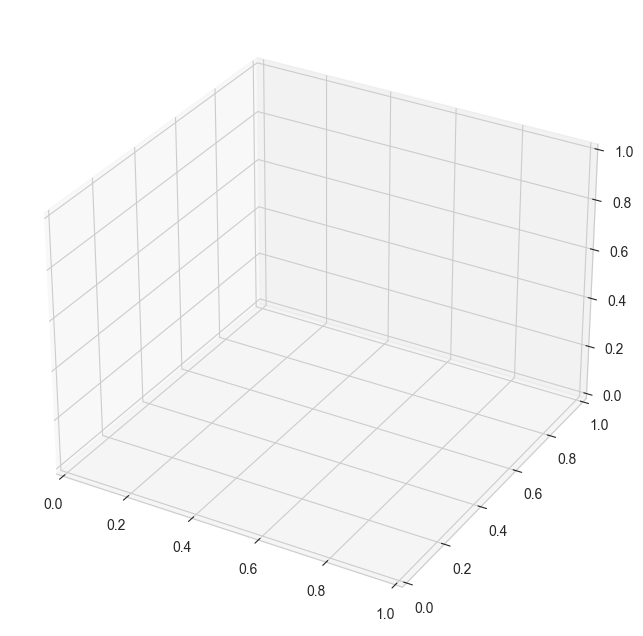

In [62]:
# 4. Elbow Method
inertia = []
k_range = range(1, 11)  # Number of clusters from 1 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_matches_scaled)
    inertia.append(kmeans.inertia_)

# Elbow plot
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', label="Inertia")

# Highlight the elbow with a red dashed circle
optimal_k = 4  # Assuming the elbow is at k=4
#circle = plt.Circle((optimal_k, inertia[optimal_k-1]), 0.5, color='red', fill=False, linestyle='--', linewidth=2)
#plt.gca().add_artist(circle)

# Add the red point for the elbow
plt.scatter(optimal_k, inertia[optimal_k-1], color='red', s=100, edgecolors='black', linewidth=2, zorder=5)

# Show the inertia value at the elbow point
plt.text(optimal_k + 0.1, inertia[optimal_k-1] - 500, f'Inertia: {inertia[optimal_k-1]:,.2f}', fontsize=12)

plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Determining Optimal Number of Clusters')

plt.show()

# 5. Apply KMeans with the optimal number of clusters (e.g., k=4)
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans_optimal.fit_predict(df_matches_scaled)

# 6. Calculate the percentage of customers in each cluster
cluster_counts = df['Cluster'].value_counts(normalize=True) * 100

# Calculate the absolute number of customers in each cluster
cluster_sizes = df['Cluster'].value_counts()

# Print the number and percentage for each cluster
print("\nNumber and percentage of customers in each cluster:")
for cluster in cluster_sizes.index:
    percentage = cluster_counts[cluster]
    size = cluster_sizes[cluster]
    print(f"Cluster {cluster}: {size} customers ({percentage:.2f}%)")


# 7. 3D Scatter plot based on RFM
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster with different colors
colors = ['blue', 'purple', 'yellow', 'orange']  # 4 distinct colors

for i, cluster in enumerate(np.unique(df['Cluster'])):
    ax.scatter(df['Recency'][df['Cluster'] == cluster], 
            df['Frequency'][df['Cluster'] == cluster], 
            df['Monetary'][df['Cluster'] == cluster], 
            c=colors[i], label=f'Cluster {cluster}', s=50, alpha=0.6)

# Add labels and title
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Visualization of Clusters based on RFM')

# Add legend
ax.legend(title="Clusters")

# Show the plot
plt.show()


# Calcolare le medie delle variabili RFM per ciascun cluster
cluster_centroids = df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
print(cluster_centroids)


**metodo tecnico**

In [25]:
print("Iniziando l'analisi PCA e clustering...")

# 1. Preparazione dei dati
print("\n1. Selezione e preparazione dei dati...")
features_for_pca = df_matches.select_dtypes(include=[np.number]).columns
X = df_matches[features_for_pca]

Iniziando l'analisi PCA e clustering...

1. Selezione e preparazione dei dati...


In [26]:
# 2. Normalizzazione
print("2. Normalizzazione dei dati...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("✓ Dati normalizzati")

2. Normalizzazione dei dati...
✓ Dati normalizzati


In [27]:
# 3. Applicazione PCA
print("\n3. Applicazione PCA...")
pca = PCA(n_components=0.8)  # mantiene l'80% della varianza
X_pca = pca.fit_transform(X_scaled)
print(f"✓ PCA applicata - Numero di componenti selezionate: {pca.n_components_}")


3. Applicazione PCA...
✓ PCA applicata - Numero di componenti selezionate: 3


In [43]:
# 4. Determinazione numero ottimale di cluster
print("\n4. Calcolo del numero ottimale di cluster...")
wcss = []
k_range = range(1, 11)

# Calcolo WCSS per ogni k
for k in tqdm(k_range, desc="Calcolo WCSS"):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)


4. Calcolo del numero ottimale di cluster...


Calcolo WCSS: 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]



5. Visualizzazione del metodo del gomito...


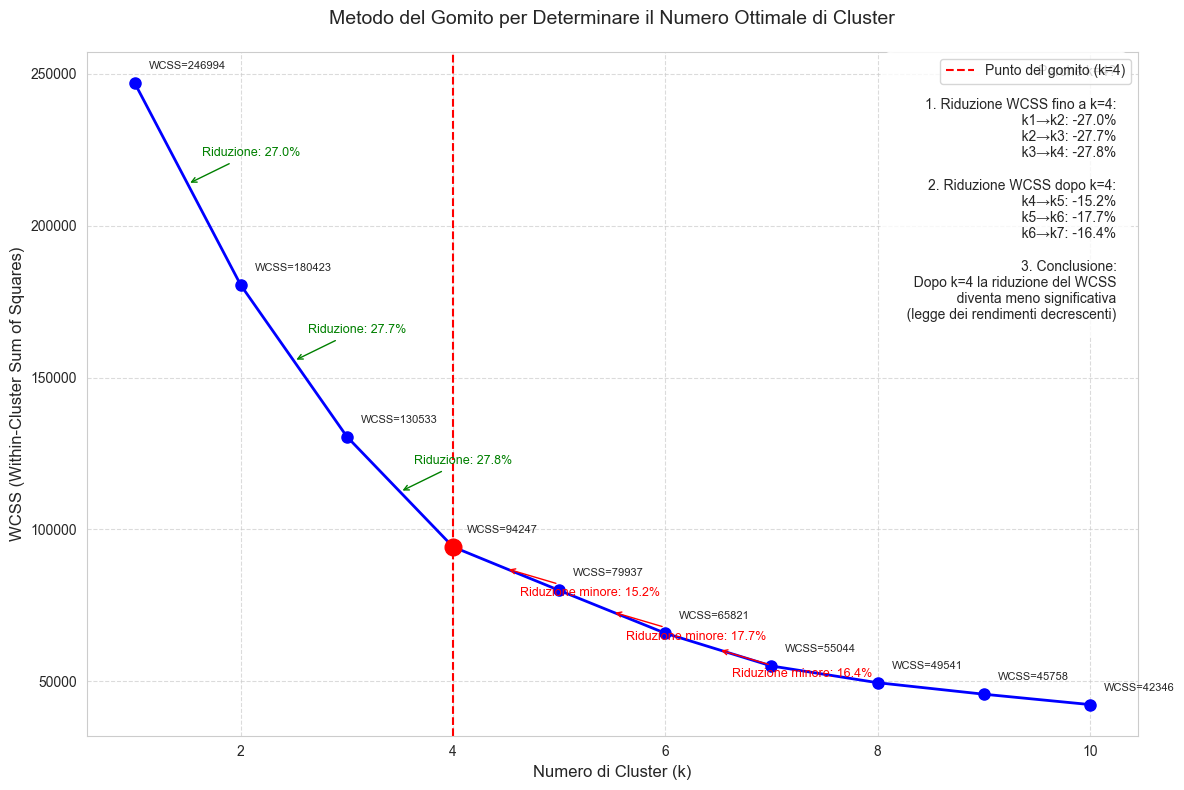


Analisi dettagliata delle riduzioni WCSS:
----------------------------------------
Da k=1 a k=2:
  WCSS: 246994 → 180423
  Riduzione: 27.0%

Da k=2 a k=3:
  WCSS: 180423 → 130533
  Riduzione: 27.7%

Da k=3 a k=4:
  WCSS: 130533 → 94247
  Riduzione: 27.8%
  >>> PUNTO DEL GOMITO <<<

Da k=4 a k=5:
  WCSS: 94247 → 79937
  Riduzione: 15.2%

Da k=5 a k=6:
  WCSS: 79937 → 65821
  Riduzione: 17.7%

Da k=6 a k=7:
  WCSS: 65821 → 55044
  Riduzione: 16.4%

Da k=7 a k=8:
  WCSS: 55044 → 49541
  Riduzione: 10.0%

Da k=8 a k=9:
  WCSS: 49541 → 45758
  Riduzione: 7.6%

Da k=9 a k=10:
  WCSS: 45758 → 42346
  Riduzione: 7.5%



In [64]:
# 5. Visualizzazione dettagliata del metodo del gomito
print("\n5. Visualizzazione del metodo del gomito...")
plt.figure(figsize=(12, 8))
plt.plot(k_range, wcss, 'bo-', linewidth=2, markersize=8)
plt.title('Metodo del Gomito per Determinare il Numero Ottimale di Cluster', fontsize=14, pad=20)
plt.xlabel('Numero di Cluster (k)', fontsize=12)
plt.ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Calcolo della riduzione percentuale del WCSS
k_optimal = 4
reductions = []
for i in range(1, len(wcss)):
    reduction = ((wcss[i-1] - wcss[i]) / wcss[i-1]) * 100
    reductions.append(reduction)
    
# Annotazione del punto del gomito
plt.axvline(x=k_optimal, color='r', linestyle='--', label=f'Punto del gomito (k={k_optimal})')
plt.plot(k_optimal, wcss[k_optimal-1], 'ro', markersize=12)

# Box informativo con spiegazione dettagliata
info_text = f'Perché k={k_optimal}?\n\n'
info_text += f'1. Riduzione WCSS fino a k=4:\n'
for i in range(3):
    info_text += f'   k{i+1}→k{i+2}: -{reductions[i]:.1f}%\n'
info_text += f'\n2. Riduzione WCSS dopo k=4:\n'
for i in range(3, 6):
    info_text += f'   k{i+1}→k{i+2}: -{reductions[i]:.1f}%\n'
info_text += '\n3. Conclusione:\n'
info_text += '   Dopo k=4 la riduzione del WCSS\n   diventa meno significativa\n   (legge dei rendimenti decrescenti)'

plt.text(0.98, 0.98, info_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round,pad=1', facecolor='white', alpha=0.8),
         fontsize=10)

# Annotazioni dei valori WCSS
for i, val in enumerate(wcss):
    plt.annotate(f'WCSS={val:.0f}', 
                xy=(i+1, val),
                xytext=(10, 10),
                textcoords='offset points',
                fontsize=8)

# Evidenziazione delle riduzioni significative
for i in range(k_optimal-1):
    plt.annotate(f'Riduzione: {reductions[i]:.1f}%',
                xy=((i+1.5), (wcss[i] + wcss[i+1])/2),
                xytext=(10, 20),
                textcoords='offset points',
                fontsize=9,
                color='green',
                arrowprops=dict(arrowstyle='->',
                              color='green'))

# Evidenziazione delle riduzioni meno significative
for i in range(k_optimal-1, k_optimal+2):
    plt.annotate(f'Riduzione minore: {reductions[i]:.1f}%',
                xy=((i+1.5), (wcss[i] + wcss[i+1])/2),
                xytext=(10, -20),
                textcoords='offset points',
                fontsize=9,
                color='red',
                arrowprops=dict(arrowstyle='->',
                              color='red'))

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Stampa analisi numerica
print("\nAnalisi dettagliata delle riduzioni WCSS:")
print("----------------------------------------")
for i in range(len(reductions)):
    print(f"Da k={i+1} a k={i+2}:")
    print(f"  WCSS: {wcss[i]:.0f} → {wcss[i+1]:.0f}")
    print(f"  Riduzione: {reductions[i]:.1f}%")
    if i == k_optimal-2:
        print("  >>> PUNTO DEL GOMITO <<<")
    print()

In [65]:
# 6. Applicazione K-means con k ottimale
k_optimal = 4  # questo valore può essere modificato in base al grafico del gomito
print(f"\n6. Applicazione K-means con {k_optimal} cluster...")
kmeans = KMeans(n_clusters=k_optimal, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)


6. Applicazione K-means con 4 cluster...


In [66]:
# 7. Aggiunta delle etichette dei cluster al DataFrame originale
df_matches['Cluster'] = cluster_labels
print("✓ Clustering completato")

✓ Clustering completato


In [67]:
# 8. Analisi dei cluster
print("\n8. Analisi dei cluster:")
for i in range(k_optimal):
    cluster_size = np.sum(cluster_labels == i)
    print(f"\nCluster {i}:")
    print(f"Numero di partite: {cluster_size}")
    print(f"Percentuale del totale: {cluster_size/len(df_matches)*100:.2f}%")


8. Analisi dei cluster:

Cluster 0:
Numero di partite: 4562
Percentuale del totale: 9.44%

Cluster 1:
Numero di partite: 21824
Percentuale del totale: 45.14%

Cluster 2:
Numero di partite: 1805
Percentuale del totale: 3.73%

Cluster 3:
Numero di partite: 20153
Percentuale del totale: 41.69%



9. Creazione visualizzazione dei cluster...


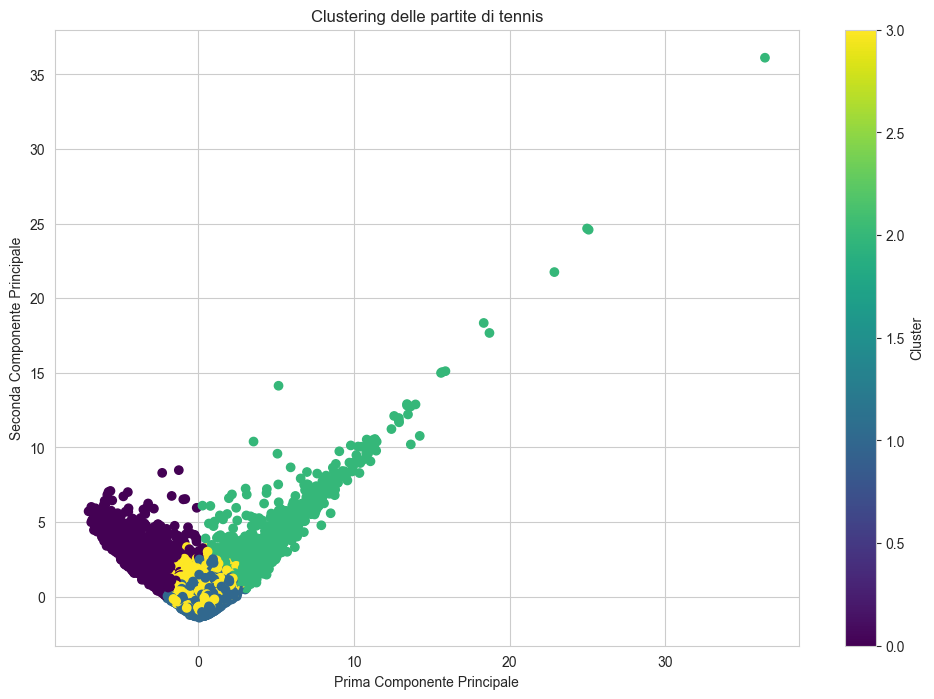


✓ Analisi completata!


In [68]:
# 9. Visualizzazione dei cluster (prime due componenti PCA)
print("\n9. Creazione visualizzazione dei cluster...")
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Clustering delle partite di tennis')
plt.xlabel('Prima Componente Principale')
plt.ylabel('Seconda Componente Principale')
plt.colorbar(scatter, label='Cluster')
plt.show()


10. Creazione visualizzazione 3D dei cluster...


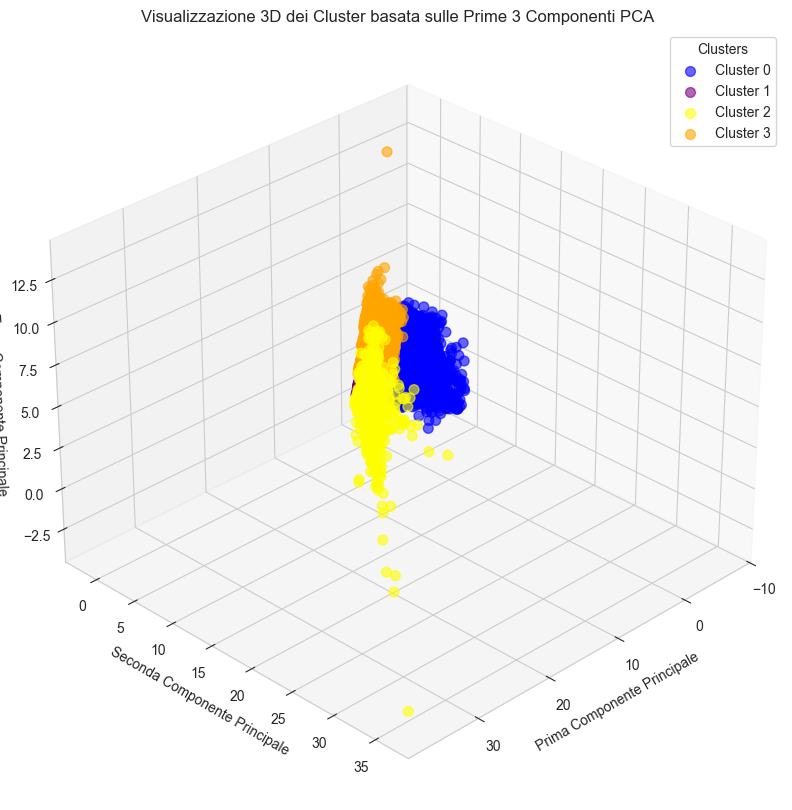


Caratteristiche medie dei cluster:
-----------------------------------
              PC1       PC2       PC3
Cluster                              
0       -2.939689  2.036352 -0.456962
1        0.228487 -0.500376 -0.821541
2        4.125117  3.242081 -0.375816
3        0.048554 -0.209477  1.026761

Analisi delle feature originali per cluster:
-------------------------------------------
         ranking_diff  avg_ranking  points_diff  total_points  total_games  \
Cluster                                                                      
0           46.175362    25.834722  6324.324858   9982.060938    25.475011   
1           54.077300    68.760424   795.747801   2255.437042    19.592009   
2          518.644321   341.273961   955.518560   1081.663712    23.458726   
3           56.259664    68.121148   846.336277   2306.076068    32.640798   

         games_diff  
Cluster              
0          7.626699  
1          5.445290  
2          6.898061  
3          8.694686  

✓ Analis

In [70]:
# Visualizzazione 3D dei cluster usando le prime 3 componenti PCA
print("\n10. Creazione visualizzazione 3D dei cluster...")
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Colori distinti per ogni cluster
colors = ['blue', 'purple', 'yellow', 'orange']  # 4 colori per 4 cluster

# Scatter plot per ogni cluster
for i in range(k_optimal):
    mask = cluster_labels == i
    ax.scatter(X_pca[mask, 0], 
              X_pca[mask, 1], 
              X_pca[mask, 2],
              c=colors[i], 
              label=f'Cluster {i}', 
              s=50, 
              alpha=0.6)

# Aggiungi etichette e titolo
ax.set_xlabel('Prima Componente Principale')
ax.set_ylabel('Seconda Componente Principale')
ax.set_zlabel('Terza Componente Principale')
ax.set_title('Visualizzazione 3D dei Cluster basata sulle Prime 3 Componenti PCA')

# Aggiungi legenda
ax.legend(title="Clusters")

# Ruota il grafico per una migliore visualizzazione
ax.view_init(30, 45)

plt.show()

# Calcola e mostra i centroidi dei cluster
print("\nCaratteristiche medie dei cluster:")
print("-----------------------------------")
cluster_centroids = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
cluster_centroids['Cluster'] = cluster_labels
centroids_mean = cluster_centroids.groupby('Cluster').mean()
print(centroids_mean)

# Analisi delle feature originali per cluster
print("\nAnalisi delle feature originali per cluster:")
print("-------------------------------------------")
df_matches['Cluster'] = cluster_labels
features_analysis = df_matches.groupby('Cluster')[features_for_pca].mean()
print(features_analysis)

print("\n✓ Analisi completata!")

Average silhouette score: 0.2967


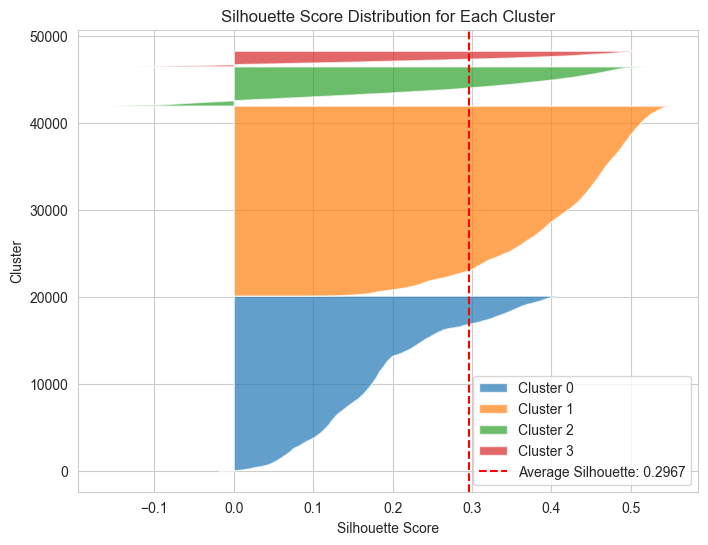

In [72]:
from sklearn.metrics import silhouette_samples

# Calculate silhouette scores for each point
silhouette_values = silhouette_samples(df_matches_scaled, kmeans_optimal.labels_)

# Calculate the average silhouette score
silhouette_avg = np.mean(silhouette_values)
print(f"Average silhouette score: {silhouette_avg:.4f}")

# Create a plot for the silhouette scores for each cluster
fig, ax = plt.subplots(figsize=(8, 6))

# For each cluster, calculate and plot the silhouette scores
y_lower, y_upper = 0, 0
for i in range(optimal_k):
    # Get the silhouette scores for points in cluster i
    cluster_silhouette_values = silhouette_values[kmeans_optimal.labels_ == i]
    
    # Sort the silhouette scores for cluster i
    cluster_silhouette_values.sort()
    
    # Calculate the limits for each cluster
    y_upper = y_lower + len(cluster_silhouette_values)
    
    # Plot the silhouette scores for the cluster i
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, alpha=0.7, label=f"Cluster {i}")
    
    # Update the lower limit for the next cluster
    y_lower = y_upper

# Plot a vertical line for the average silhouette score
ax.axvline(x=silhouette_avg, color="red", linestyle="--", label=f"Average Silhouette: {silhouette_avg:.4f}")

# Add labels and title
ax.set_xlabel("Silhouette Score")
ax.set_ylabel("Cluster")
ax.set_title("Silhouette Score Distribution for Each Cluster")
ax.legend()

plt.show()

## DBSCAN